# get large-scale TC seed predictor Z

we need beta,relative vorticity, absolute vorticity, and d vor/dy

In [9]:
import xarray as xr
import numpy as np
import pandas as pd
import hvplot.xarray
import matplotlib
import matplotlib.pyplot as plt
import time
import dask
import warnings
warnings.filterwarnings('ignore')

In [10]:
from geocat.viz import util as gvutil
from geocat.viz import cmaps as gvcmaps

In [11]:
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

## 1. read in observational climatology from jra55: uv850, vor

In [12]:
radius = 6.37122* 1e06
omega = 7.2921 * 1e-5 #rad/s
dsv = xr.open_dataset('/glade/work/huili7/S2S/clim_data/jra55_climatology_uv850_2002-2019.nc')
vor = dsv.vo 
u850 = dsv.u
v850 = dsv.v
coriolis =  2 * omega * np.sin(np.deg2rad(dsv.latitude)) 


In [13]:
# boradcast to get 3d coriolis
a2, F = xr.broadcast(vor, coriolis)

In [14]:
# get beta df/dy
beta = 2 * omega * np.cos(np.deg2rad(dsv.latitude)) / radius

In [15]:
a1, BETA = xr.broadcast(vor, beta)

now get latitude in rad

In [16]:
def calc_dvdy(ds, axis,vor):
    lat_rad = np.deg2rad(ds)
    vor_y = np.gradient(vor, lat_rad, axis=axis)
    vor_y = vor_y/ radius
    dvdy = vor.copy(data=vor_y)
    return dvdy

In [17]:
dvdy = calc_dvdy(dsv.latitude, 1, vor)

In [18]:
vor = xr.where(vor* F>0, vor, 0)

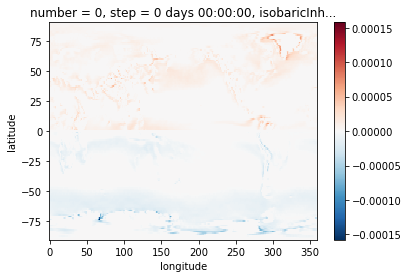

In [19]:
vor.isel(month=0).plot()

In [20]:
Z = np.abs(F+vor) / np.sqrt(np.abs(BETA+dvdy) * 20.)

In [21]:
dw = xr.open_dataset('../clim_data/jra55_climatology_w500_2002-2019.nc')

In [22]:
w500 = dw.w

In [23]:
pred = w500 * Z * -1


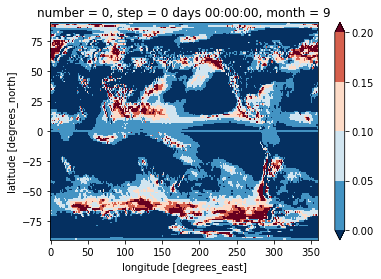

In [24]:
pred.isel(month=8).plot(levels=np.linspace(0,0.2,5))

## now read in the S2S
have to regrid the S2S vorticity and observed Z to the new grids

In [25]:
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    dsw = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_w500_week'+week+'_monclim.nc')
    var_list.append(dsw.wap_500)
S2S_w500 = xr.concat(var_list,dim='week')
S2S_w500['week'] = np.arange(1,7) 

In [90]:
S2S_w500

<xarray.DataArray 'wap_500' (week: 6, month: 12, member: 10, lat: 181, lon: 360)>
array([[[[[ 3.67821194e-02,  3.67821194e-02,  3.67821194e-02, ...,
            3.67821194e-02,  3.67821194e-02,  3.67821194e-02],
          [ 1.76454838e-02,  1.77591834e-02,  1.78935435e-02, ...,
            1.74341705e-02,  1.75231826e-02,  1.75870825e-02],
          [ 5.38920471e-03,  5.04400488e-03,  4.72615380e-03, ...,
            6.83879387e-03,  6.31699804e-03,  5.82252350e-03],
          ...,
          [ 1.59064773e-02,  1.59461945e-02,  1.59761291e-02, ...,
            1.56769082e-02,  1.57751031e-02,  1.58513878e-02],
          [ 1.07774874e-02,  1.05701732e-02,  1.03554027e-02, ...,
            1.14216432e-02,  1.12082139e-02,  1.09933559e-02],
          [ 6.72890525e-03,  6.72890525e-03,  6.72890525e-03, ...,
            6.72890525e-03,  6.72890525e-03,  6.72890525e-03]],

         [[ 3.84685509e-02,  3.84685509e-02,  3.84685509e-02, ...,
            3.84685509e-02,  3.84685509e-02,  3.84685509e-02],
          [ 1.81742013e-02,  1.83712244e-02,  1.85790081e-02, ...,
            1.79699026e-02,  1.80823263e-02,  1.81306880e-02],
          [ 6.08965615e-03,  5.76828327e-03,  5.47139859e-03, ...,
            7.54372682e-03,  7.01848092e-03,  6.51876396e-03],
...
           -6.23501418e-03, -6.23541232e-03, -6.23019272e-03],
          [-6.24966249e-03, -6.38509542e-03, -6.49485318e-03, ...,
           -5.84825780e-03, -5.98408934e-03, -6.11729268e-03],
          [-4.85232938e-03, -4.85232938e-03, -4.85232938e-03, ...,
           -4.85232938e-03, -4.85232938e-03, -4.85232938e-03]],

         [[ 5.33045596e-03,  5.33045596e-03,  5.33045596e-03, ...,
            5.33045596e-03,  5.33045596e-03,  5.33045596e-03],
          [ 2.72027776e-03,  2.73099053e-03,  2.76587228e-03, ...,
            2.46778084e-03,  2.55445321e-03,  2.64343573e-03],
          [ 7.97109399e-03,  7.59496028e-03,  7.20766047e-03, ...,
            9.21569113e-03,  8.79484322e-03,  8.37250613e-03],
          ...,
          [-4.47480474e-03, -4.40207450e-03, -4.30522813e-03, ...,
           -4.68385220e-03, -4.60920110e-03, -4.53872373e-03],
          [-3.64147755e-03, -3.91902309e-03, -4.18517366e-03, ...,
           -2.78887525e-03, -3.07356357e-03, -3.35749402e-03],
          [-2.24354537e-03, -2.24354537e-03, -2.24354537e-03, ...,
           -2.24354537e-03, -2.24354537e-03, -2.24354537e-03]]]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * week     (week) int64 1 2 3 4 5 6

In [26]:
# absolute vorticity
var_list = []
for iw in np.arange(1,7):
    week = iw.astype(str)
    ds = xr.open_dataset('/glade/scratch/huili7/S2S_data/S2S_vor850_week'+week+'_monclim.nc')
    var_list.append(ds.vo)
S2S_vo850_raw = xr.concat(var_list,dim='week')
S2S_vo850_raw['week'] = np.arange(1,7)

In [27]:
S2S_vo850_raw

<xarray.DataArray 'vo' (week: 6, month: 12, member: 10, lat: 181, lon: 360)>
array([[[[[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [-0.00017108, -0.00017012, -0.00016932, ..., -0.00017315,
           -0.00017256, -0.00017194],
          [-0.0001619 , -0.00016133, -0.00016081, ..., -0.00016387,
           -0.00016339, -0.00016288],
          ...,
          [ 0.00015673,  0.00015659,  0.00015645, ...,  0.00015713,
            0.00015699,  0.00015685],
          [ 0.00016916,  0.00016895,  0.00016874, ...,  0.00016978,
            0.0001696 ,  0.00016941],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan]],

         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [-0.00017223, -0.00017135, -0.00017055, ..., -0.00017434,
           -0.00017376, -0.00017315],
          [-0.00016288, -0.00016228, -0.00016168, ..., -0.00016475,
           -0.00016421, -0.00016366],
...
          [ 0.0001534 ,  0.00015329,  0.00015317, ...,  0.00015376,
            0.00015365,  0.00015354],
          [ 0.00015819,  0.00015807,  0.00015796, ...,  0.00015824,
            0.00015821,  0.00015819],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan]],

         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [-0.00016485, -0.00016402, -0.00016326, ..., -0.00016679,
           -0.00016625, -0.00016568],
          [-0.00015824, -0.0001576 , -0.00015701, ..., -0.00016001,
           -0.00015945, -0.00015885],
          ...,
          [ 0.00015373,  0.00015357,  0.0001534 , ...,  0.00015436,
            0.00015417,  0.00015397],
          [ 0.00016193,  0.0001617 ,  0.00016148, ...,  0.00016256,
            0.00016235,  0.00016213],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan]]]]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * member   (member) int64 0 1 2 3 4 5 6 7 8 9
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * week     (week) int64 1 2 3 4 5 6

In [28]:
# this is absolute vorticity, we need to get relative vorticity as well.

In [29]:
coriolis2 =  2 * omega * np.sin(np.deg2rad(ds.lat)) 


In [30]:
S2S_vor_rel = S2S_vo850_raw - coriolis2

 now get BETA, dvdy

In [31]:
beta = 2 * omega * np.cos(np.deg2rad(ds.lat)) / radius

In [32]:
a3, S2S_BETA = xr.broadcast(S2S_vor_rel, beta)

In [33]:
S2S_dvdy = calc_dvdy(ds.lat, 3, S2S_vor_rel)

In [34]:
S2S_vor_rel = xr.where(S2S_vor_rel * coriolis2 >0,S2S_vor_rel,0)

In [35]:
S2S_Z = np.abs(S2S_vo850_raw) / np.sqrt(np.abs(S2S_BETA+S2S_dvdy) * 20.)

In [37]:
S2S_Z = np.abs(S2S_vor_rel+coriolis2) / np.sqrt(np.abs(S2S_BETA+S2S_dvdy) * 20.)

In [38]:
S2S_pred = S2S_Z * S2S_w500 * -1 

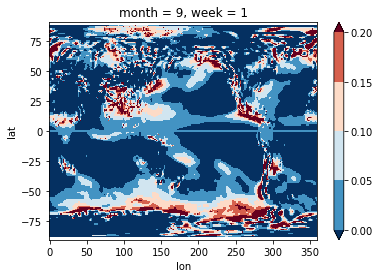

In [39]:
S2S_pred.isel(week=0, month=8).mean('member').plot(levels=np.linspace(0,0.2,5))

In [ ]:
S2S_pred.isel(week=0, month=8).mean('member').plot(levels=np.linspace(0,0.2,5))

In [40]:
S2S_pred_regrid= S2S_pred.interp(lat = w500.latitude,lon = w500.longitude, method='linear')


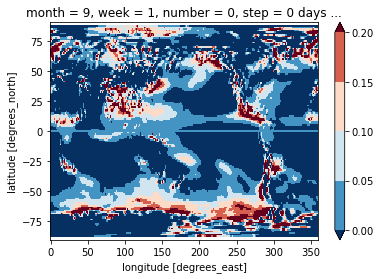

In [41]:
S2S_pred_regrid.isel(week=0,month=8).mean('member').plot(levels=np.linspace(0,0.2,5))

In [42]:
pred_diff = S2S_pred_regrid.isel(member=0).copy(data=S2S_pred_regrid.mean('member').data - pred.data)

In [43]:
pred_n_summer = pred_diff.sel(month=slice(5,10)).mean('month')
pred_n_winter = pred_diff.sel(month=[1,2,3,4,11,12]).mean('month')

In [44]:
pred_summer = pred.sel(month=slice(5,10)).mean('month')
pred_winter = pred.sel(month=[1,2,3,4,11,12]).mean('month')

In [46]:
pred_summer_diff1  = pred_n_summer - pred_n_summer.sel(week=1)
pred_winter_diff1 = pred_n_winter - pred_n_winter.sel(week=1)

In [50]:
## define gpi plotting funcition
def var_plot_panels(variable, i,j, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-110, 170),
                                 ylim=(0, 40),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


In [51]:
## define gpi plotting funcition
def var_plot_panels_winter(variable, i,j, levels, colormap, title,colorbar):
    ax1= fig.add_subplot(spec[i,j], projection=ccrs.PlateCarree(central_longitude=180))
    ax1.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    ax1.add_feature(cfeature.COASTLINE, linewidth=0.5, zorder=1)
    contour = variable.plot.contourf(ax=ax1,
                           transform=ccrs.PlateCarree(),
                           levels=levels,
                           extend='both',
                            cmap = colormap,
                           add_colorbar=False,
                           add_labels=False,
                            zorder=0)
    if colorbar==True:
        plt.colorbar(contour,
                     ax=ax1,
                     ticks=np.arange(0,20),
                     orientation='horizontal',
                     pad=0.075,
                     drawedges=True,
                     shrink=0.7)

    gvutil.set_titles_and_labels(ax1,maintitle=title,
                             maintitlefontsize=15)
    gvutil.set_axes_limits_and_ticks(ax1, xlim=(-150, 130),
                                 ylim=(-40, 0),
                                 xticks=np.linspace(-180, 180, 10),
                                 yticks=np.linspace(-90, 90, 7))

    gvutil.add_major_minor_ticks(ax1, labelsize=12)
    gvutil.add_lat_lon_ticklabels(ax1)


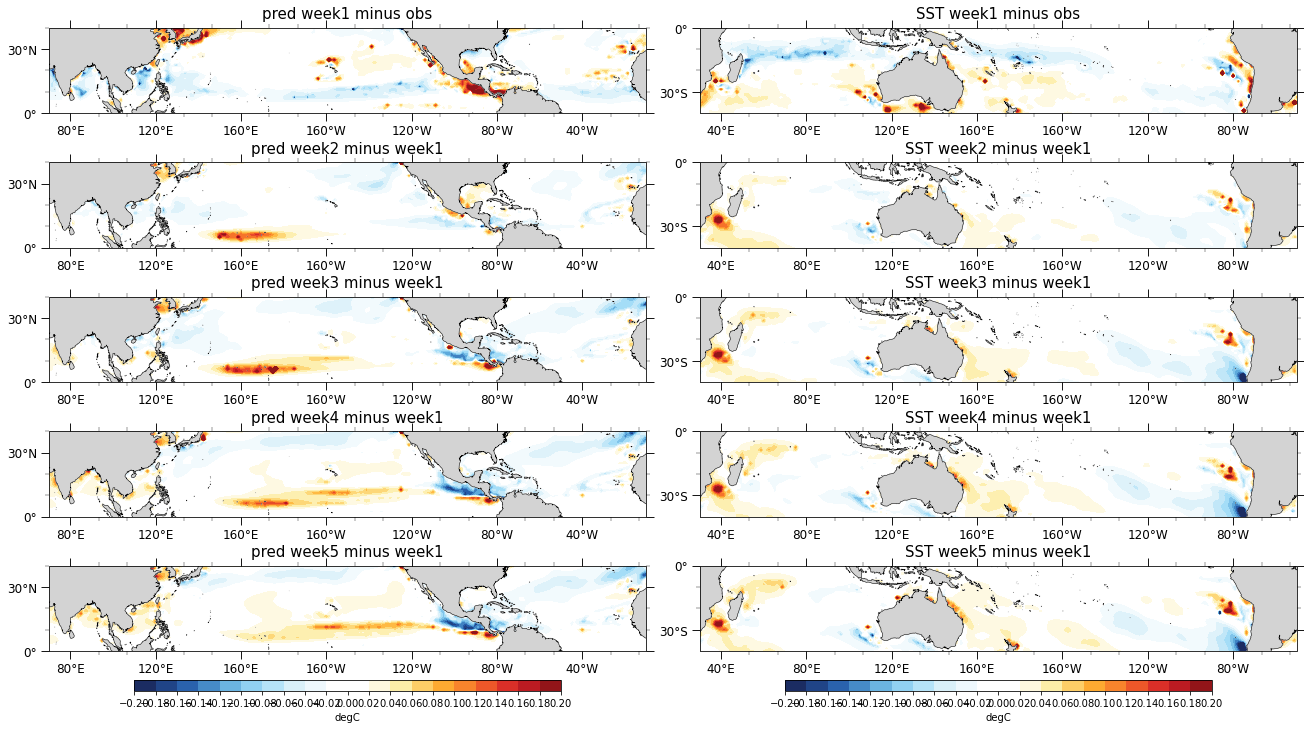

In [52]:
levels=np.linspace(-0.2,0.2, 21)
fig = plt.figure(figsize=(18, 10),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 6,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)

# plot SST
var_plot_panels(pred_n_summer[0],0,0,levels,gvcmaps.BlueWhiteOrangeRed,"pred week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels(pred_summer_diff1[i],i,0,levels,gvcmaps.BlueWhiteOrangeRed,"pred week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed

bounds = np.linspace(-0.2,0.2,21).tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('degC')


# plot winter
cmap=gvcmaps.BlueWhiteOrangeRed
var_plot_panels_winter(pred_n_winter[0],0,1,levels,cmap,"SST week1 minus obs", False)

for i in np.arange(1,5):
    var_plot_panels_winter(pred_winter_diff1[i],i,1,levels,cmap,"SST week"+(i+1).astype(str)+" minus week1", False)

# add common colarbar
ax= fig.add_subplot(spec[5,1])
ax.set_aspect(0.025)

bounds = levels.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                #boundaries=[-10] + bounds + [25],
                                #extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')
cb.set_label('degC')




#plt.show()
#plt.savefig('SST_bias_climo.pdf')

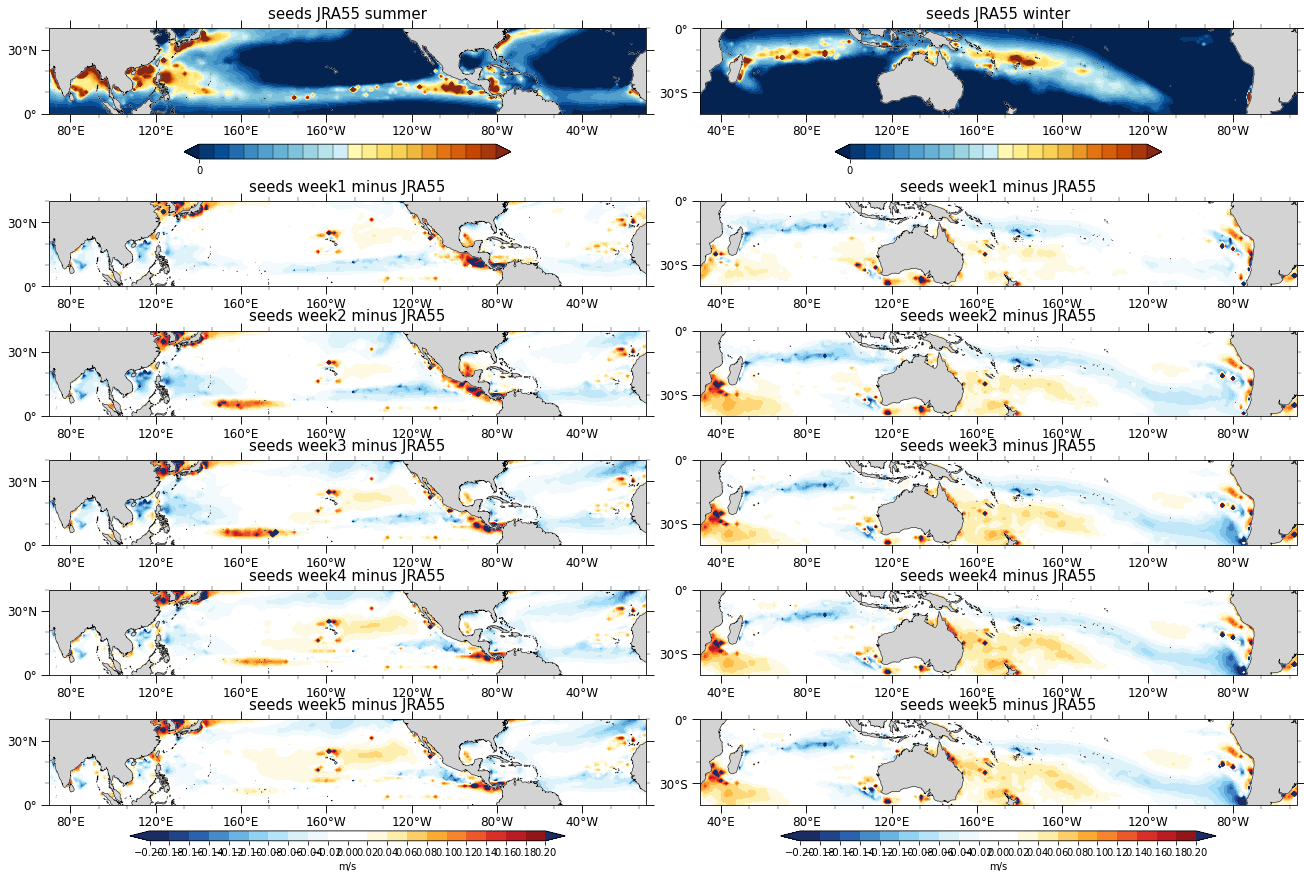

In [180]:
levels=np.linspace(0,0.2,21)
levels2 =np.linspace(-0.2,0.2,21)
fig = plt.figure(figsize=(18, 12),constrained_layout=True)
fig.tight_layout(pad=-2)

nrows, ncols = 7,2
widths = [1, 1]
heights = [1, 1, 1, 1, 1, 1,0.1]

spec = fig.add_gridspec(nrows, ncols,width_ratios=widths,
                          height_ratios=heights)
cmap=gvcmaps.BlueWhiteOrangeRed

# plot observations
var_plot_panels(pred_summer,0,0,levels,gvcmaps.BlueYellowRed,"seeds JRA55 summer", True)
var_plot_panels(pred_n_summer.isel(week=0),1,0,levels2,cmap,"seeds week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels(pred_n_summer[i],i+1,0,levels2,gvcmaps.BlueWhiteOrangeRed,"seeds week"+(i+1).astype(str)+" minus JRA55", False)

# add common colarbar
ax= fig.add_subplot(spec[6,0])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')

#--------------------
# winter
# plot observations
var_plot_panels_winter(pred_winter,0,1,levels,gvcmaps.BlueYellowRed,"seeds JRA55 winter", True)
var_plot_panels_winter(pred_n_winter.isel(week=0),1,1,levels2,cmap,"seeds week1 minus JRA55", False)

for i in np.arange(1,5):
    var_plot_panels_winter(pred_n_winter[i],i+1,1,levels2,gvcmaps.BlueWhiteOrangeRed,"seeds week"+(i+1).astype(str)+" minus JRA55", False)

# add common colarbar
ax= fig.add_subplot(spec[6,1])
ax.set_aspect(0.025)
cmap=gvcmaps.BlueWhiteOrangeRed
cmap.set_over(cmap(0))
cmap.set_under(cmap(cmap.N))
bounds = levels2.tolist()
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)
cb = matplotlib.colorbar.ColorbarBase(ax, orientation='horizontal', norm =norm,
                                      cmap=cmap,
                                boundaries=[-10] + bounds + [25],
                                extend='both',
                                ticks=bounds,  # optional
                                spacing='uniform')

cb.set_label('m/s')
plt.savefig('seeds_pattern_compare_obs.pdf')



In [4]:
import dask

In [5]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client


In [6]:
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='5GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB', # Specify resources
    project='P93300313', # Input your project ID here
    walltime='04:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(12)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status'})

# Setup your client
client = Client(cluster)


In [7]:
client


Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.54:33737,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/huili7/proxy/127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [10]:
ds = xr.open_mfdataset('/glade/scratch/huili7/S2S_data/pr_sfc_2002*m01.nc',
                      combine='nested', concat_dim='newtime')






In [11]:
ds

,Array,Chunk
Bytes,2.95 GiB,77.55 MiB
Shape,"(39, 312, 181, 360)","(1, 312, 181, 360)"
Count,433 Tasks,39 Chunks
Type,float32,numpy.ndarray


In [12]:
prec = ds.pr_sfc.isel(time=slice(0,7)) 

In [13]:
prec

,Array,Chunk
Bytes,67.86 MiB,1.74 MiB
Shape,"(39, 7, 181, 360)","(1, 7, 181, 360)"
Count,472 Tasks,39 Chunks
Type,float32,numpy.ndarray


In [14]:
np.nanpercentile(prec, 99.5)

0.0003354124992620191

(array([4.40699e+05, 1.20260e+04, 2.33900e+03, 7.08000e+02, 2.22000e+02,
        7.70000e+01, 1.80000e+01, 1.80000e+01, 9.00000e+00, 4.00000e+00]),
 array([0.        , 0.00014375, 0.0002875 , 0.00043125, 0.000575  ,
        0.00071876, 0.00086251, 0.00100626, 0.00115001, 0.00129376,
        0.00143751], dtype=float32),
 <BarContainer object of 10 artists>)

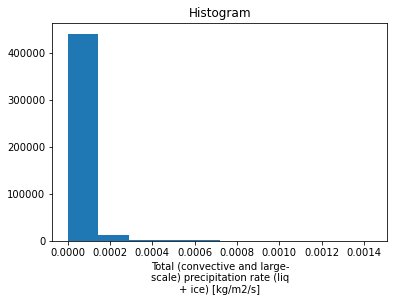

In [15]:
prec.plot()

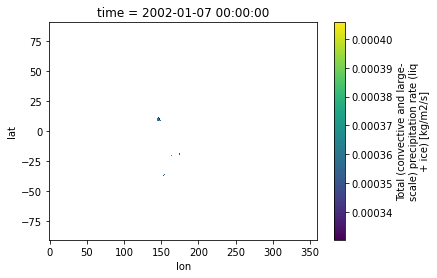

In [17]:
prec.where(prec>3.3e-4).isel(time=0,newtime=0).plot()

In [4]:
dsp = xr.open_dataset('../week1_blobs_2002.01.nc')

In [5]:
dsp

<xarray.Dataset>
Dimensions:    (ncl0: 5000, ncl1: 9, ncl2: 100)
Dimensions without coordinates: ncl0, ncl1, ncl2
Data variables:
    traj_data  (ncl0, ncl1, ncl2) float32 ...

In [8]:
dsp.traj_data[:,:,0]

<xarray.DataArray 'traj_data' (ncl0: 5000, ncl1: 9, ncl2: 100)>
[4500000 values with dtype=float32]
Dimensions without coordinates: ncl0, ncl1, ncl2

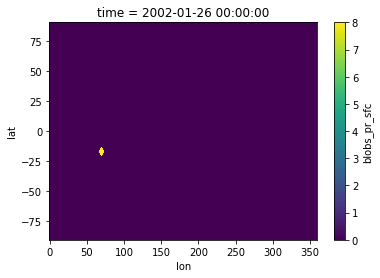

In [82]:
dsp.blobs_pr_sfc.isel(time=19).plot()

In [61]:
dsp.blobs_pr_sfc.where(dsp.blobs_pr_sfc>0,drop=True).time

<xarray.DataArray 'time' (time: 37)>
array([cftime.DatetimeNoLeap(2002, 1, 10, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 11, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 12, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 13, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 14, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 18, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 19, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 20, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 21, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 22, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 23, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 24, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 25, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 26, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 27, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 28, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 29, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 1, 30, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 2, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 3, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 4, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 5, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 6, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 7, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 8, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 9, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 10, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 11, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 12, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 13, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 17, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2002, 2, 18, 0, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 2002-01-10 00:00:00 ... 2002-02-18 00:00:00
Attributes:
    long_name:  time